In [1]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [39]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.5
sim.parameters["n_variants"] = 20

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
@mr_sim.variable
def x_e_variance(sim):
    """Variance for the environmental component of the exposure."""
    target = 1 - sim.parameters["h2"] - sim.parameters["ux_effect"] ** 2
    if target < 0:
        raise ValueError("Unacheivable value.")
    return target
sim.add_sim_parameter(x_e_variance)

sim.parameters["y_e_std"] = 1

In [40]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.2,
        0.4,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
variants = []
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    variants.append(variant)

sim.add_variables(variants)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
# sim.add_sim_parameter(
#     mr_sim.Normal(
#         "gx_effects",
#         mu=0,
#         sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
#         size=sim.parameters["n_variants"]
#     )
# )
@mr_sim.variable
def gx_effects(sim):
    import torch
    d = np.random.dirichlet(np.ones(sim.parameters["n_variants"]))
    return np.sqrt(d * sim.parameters["h2"])

sim.add_sim_parameter(gx_effects)

    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
        
    print("Var_G(X) = {}".format(np.var(x)))
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(
        0,
        scale=np.sqrt(sim.parameters["x_e_variance"]),
        size=sim.n
    )
    
    print("Var(X) = {}".format(np.var(x)))
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

Var_G(X) = 0.4984594226808446
Var(X) = 0.9951039716811981


In [30]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

Var_G = 0.49996761991248206
basic_simulation_model.ipynb	mr_simulation_0_sim_data.csv.gz
basic_sweep.json		mr_simulation_0_sim_parameters.json
basic_sweep_deterministic.json	mr_simulation_1_sim_data.csv.gz
mdn_tests.ipynb			mr_simulation_1_sim_parameters.json


In [31]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.003944,1,1,0,0,0,0,1,1,1,...,0,2,2,2,1,1,0,2,-0.172068,-0.008773
1,1.060878,2,0,1,2,2,0,1,1,0,...,2,1,2,0,2,2,1,1,2.087722,-1.263100
2,2.277488,1,0,1,0,0,1,1,0,1,...,1,0,1,2,0,1,1,0,0.849639,-0.677637
3,0.603609,1,1,0,2,0,0,0,1,0,...,1,1,0,0,0,1,1,1,0.181968,-0.486263
4,0.081188,0,1,1,0,1,0,2,2,0,...,1,0,2,1,2,0,1,1,0.980888,2.293569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.820117,0,1,1,1,0,2,0,0,1,...,1,1,1,1,0,0,1,1,0.169342,-0.862248
99996,0.384327,1,2,1,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,-0.220608,0.293221
99997,-0.150023,1,1,0,0,1,1,0,1,0,...,1,1,0,0,1,1,0,1,-0.000145,-0.624855
99998,-1.293124,0,1,1,1,0,0,0,0,0,...,2,1,1,0,1,2,1,1,-1.068981,0.220301


In [33]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(20)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               exposure   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     4991.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        20:51:24   Log-Likelihood:            -1.0762e+05
No. Observations:              100000   AIC:                         2.153e+05
Df Residuals:                   99979   BIC:                         2.155e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4826      0.010   -258.705      0.000      -2.501      -2.464
v1             0.6446      0.004    167.837      0.000       0.637       0.652
v2             0.0864      0.003     25.017      0.000       0.080       0.093
v3             0.1360      0.004     37.745      0.000       0.129       0.143
v4             0.0627      0.003     18.092      0.000       0.056       0.070
v5             0.3157      0.004     84.581      0.000       0.308       0.323
v6             0.2345      0.003     67.448      0.000       0.228       0.241
v7             0.1853      0.004     49.084      0.000       0.178       0.193
v8             0.4159      0.004    113.698      0.000       0.409       0.423
v9             0.1039      0.004     26.703      0.000       0.096       0.112
v10            0.1635      0.004     45.472      0.000       0.156       0.171
v11            0.1770      0.003     52.270      0.000       0.170       0.184
v12            0.1603      0.003     48.016      0.000       0.154       0.167
v13            0.1767      0.003     52.995      0.000       0.170       0.183
v14            0.0043      0.003      1.251      0.211      -0.002       0.011
v15            0.1474      0.003     44.237      0.000       0.141       0.154
v16            0.3289      0.003     98.415      0.000       0.322       0.335
v17            0.1776      0.003     52.086      0.000       0.171       0.184
v18            0.2617      0.003     77.314      0.000       0.255       0.268
v19            0.2296      0.003     69.472      0.000       0.223       0.236
v20            0.2636      0.003     80.208      0.000       0.257       0.270
==============================================================================
Omnibus:                        2.487   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.497
Skew:                          -0.011   Prob(JB):                        0.287
Kurtosis:                       2.991   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

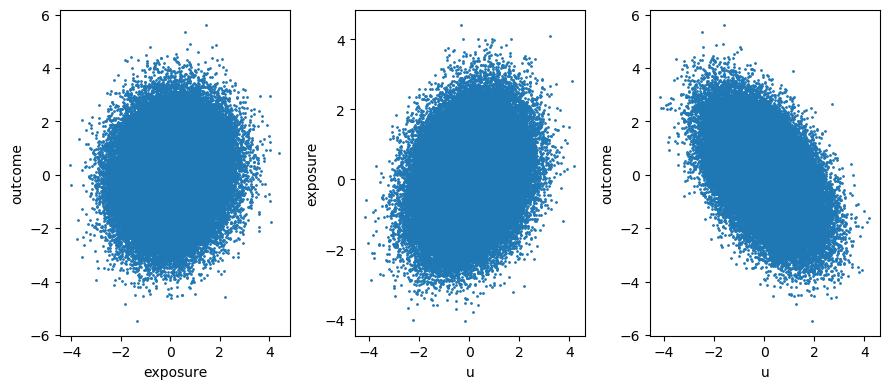

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [35]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,1.015200,0,1,2,0,0,1,0,0,0,...,0,2,0,0,0,1,1,0,-0.455746,-2.099064
1,2.650221,1,1,1,1,1,0,1,1,1,...,1,0,0,2,0,0,0,1,0.768721,-3.369456
2,-1.762871,1,1,0,1,1,1,1,0,1,...,0,0,0,1,0,0,2,0,-1.703710,2.886667
3,0.262168,0,0,1,0,1,1,1,1,0,...,2,1,0,0,1,1,1,1,0.751876,-0.234047
4,-2.485587,1,1,0,0,1,0,0,1,0,...,0,1,1,0,1,0,0,0,0.409608,3.292492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.881300,2,0,2,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1.617315,0.819156
99996,1.931438,1,0,0,1,1,0,0,0,1,...,1,0,1,1,1,1,0,0,0.400718,-0.992737
99997,0.279497,0,0,0,1,0,1,0,1,0,...,0,1,1,1,0,0,1,1,1.252964,-0.696036
99998,0.316488,0,2,1,0,1,0,0,2,1,...,2,1,0,0,1,1,1,1,0.702826,0.227990


In [36]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

Var_G = 0.46151469967853964


,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.101222,2,0,1,1,1,0,0,0,1,...,1,0,1,0,0,2,0,1,1.126671,-0.065437
1,1.239787,0,2,0,0,0,0,0,1,0,...,1,0,1,1,1,1,2,2,-0.779482,-1.626624
2,-0.817331,1,0,0,0,0,0,0,1,1,...,0,1,2,0,0,1,0,0,0.693425,1.129512
3,0.447309,1,1,0,1,0,0,0,1,0,...,1,0,1,0,0,2,0,0,1.268951,1.280451
4,0.330071,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,1,0,1,-0.558255,-0.644132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.637942,0,2,0,0,0,0,0,0,1,...,1,0,0,0,0,1,1,0,-0.051630,-1.195919
99996,-1.228203,0,1,0,0,0,0,0,0,1,...,1,1,2,1,1,0,1,0,0.156170,-0.239769
99997,-0.621449,0,2,0,1,0,2,0,1,0,...,2,0,2,2,0,1,1,1,-1.006546,0.995859
99998,-1.983414,0,1,0,0,0,1,0,0,0,...,1,2,0,2,1,2,0,0,-3.350902,2.267112
